### Developying machine learning model for time series forecast

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
features = pd.read_csv('../data/raw/features_data_set.csv')
sales = pd.read_csv('../data/raw/sales_data_set.csv')
stores = pd.read_csv('../data/raw/stores_data_set.csv')

In [3]:
sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

features['Date'] = pd.to_datetime(features.Date, dayfirst=True)
features = features.sort_values(by=['Date'], ascending=True)

sales['Date'] = pd.to_datetime(sales.Date, dayfirst=True)
sales = sales.sort_values(by=['Date'], ascending=True)

In [4]:
type_store = {row.Store:row.Type for _,row in stores.iterrows()}

In [5]:
sales_store_grouped = (sales[['Store','Weekly_Sales','Date']].groupby(['Store','Date']).agg({'Weekly_Sales':'sum'})
                       .reset_index())

In [6]:
new_dataset = pd.merge(sales_store_grouped, features, on=['Store','Date'], how='inner')

In [7]:
new_dataset = new_dataset.drop(columns=['MarkDown1','MarkDown2',
                                        'MarkDown3','MarkDown4','MarkDown5'])

new_dataset['IsHoliday'] = new_dataset['IsHoliday']*1

In [8]:
new_dataset['Type'] = new_dataset.Store.map(type_store)

new_dataset['Type'] = new_dataset.Type.map({'A':0,
                                            'B':1,
                                            'C':2})

In [9]:
from darts.timeseries import TimeSeries

Feature engineering

In [10]:
new_dataset['ma1_sales'] = new_dataset.Weekly_Sales.rolling(window=2).mean()
new_dataset['ma2_sales'] = new_dataset.Weekly_Sales.rolling(window=3).mean()
new_dataset['ma5_sales'] = new_dataset.Weekly_Sales.rolling(window=5).mean()
new_dataset['std_sales'] = new_dataset.Weekly_Sales.rolling(window=2).std()

new_dataset['month'] = new_dataset.Date.dt.month
new_dataset['day'] = new_dataset.Date.dt.day
new_dataset['year'] = new_dataset.Date.dt.year


In [11]:
new_dataset = new_dataset.dropna()

In [12]:
new_dataset

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,ma1_sales,ma2_sales,ma5_sales,std_sales,month,day,year
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,0,0,1482267.135,1.525501e+06,1572430.156,102586.408347,3,5,2010
5,1,2010-03-12,1439541.59,57.79,2.667,211.380643,8.106,0,0,1497174.135,1.468025e+06,1531600.294,81504.726773,3,12,2010
6,1,2010-03-19,1472515.79,54.58,2.720,211.215635,8.106,0,0,1456028.690,1.488955e+06,1497711.964,23316.280424,3,19,2010
7,1,2010-03-26,1404429.92,51.45,2.732,211.018042,8.106,0,0,1438472.855,1.438829e+06,1456204.314,48143.980380,3,26,2010
8,1,2010-04-02,1594968.28,62.27,2.719,210.820450,7.808,0,0,1499699.100,1.490638e+06,1493252.452,134730.966432,4,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684,0,1,718130.075,7.128328e+05,727861.790,7009.019187,9,28,2012
6431,45,2012-10-05,733455.07,64.89,3.985,192.170412,8.667,0,1,723314.510,7.232384e+05,727693.230,14340.917480,10,5,2012
6432,45,2012-10-12,734464.36,54.47,4.000,192.327265,8.667,0,1,733959.715,7.270311e+05,721283.570,713.675761,10,12,2012
6433,45,2012-10-19,718125.53,56.47,3.969,192.330854,8.667,0,1,726294.945,7.286817e+05,724461.022,11553.297487,10,19,2012


In [13]:
y_ts = TimeSeries.from_group_dataframe(new_dataset,
                                       time_col='Date',
                                       value_cols=['Weekly_Sales'],
                                       group_cols=['Store','Type'])

future_cov_ts = TimeSeries.from_group_dataframe(new_dataset,
                                                time_col='Date',
                                                value_cols=['month','day','year','IsHoliday'],
                                                group_cols=['Store','Type'])

past_cov_ts = TimeSeries.from_group_dataframe(new_dataset,
                                              time_col='Date',
                                              value_cols=['ma1_sales','ma2_sales','ma5_sales','std_sales',
                                                         'Temperature','Fuel_Price','CPI','Unemployment'],
                                              group_cols=['Store','Type']) 

In [14]:
def train_test_timeseries(y:TimeSeries,
                          future_cov:TimeSeries=None,
                          past_cov:TimeSeries=None,
                          train_size:int=0.80)-> dict:
    
    train_y, test_y = [],[]
    train_future_cov, test_future_cov = [],[]
    train_past_cov, test_past_cov = [],[]
    
    for y_single in y:
        train_y_single, test_y_single = y_single.split_before(train_size)
        train_y.append(train_y_single)
        test_y.append(test_y_single)
    for future_cov_single in future_cov:
        train_future_cov_single, test_future_cov_single = future_cov_single.split_before(train_size)
        train_future_cov.append(train_future_cov_single)
        test_future_cov.append(test_future_cov_single)
    for past_cov_single in past_cov:
        train_past_cov_single, test_past_cov_single = past_cov_single.split_before(train_size)
        train_past_cov.append(train_past_cov_single)
        test_past_cov.append(test_past_cov_single)

    return {'y_timeseries':(train_y, test_y),
            'future_cov':(train_future_cov,test_future_cov),
            'past_cov':(train_past_cov, test_past_cov)}

In [15]:
dateset_for_fitting = train_test_timeseries(y_ts,future_cov=future_cov_ts,
                                            past_cov=past_cov_ts)

In [16]:
y_train, y_test = dateset_for_fitting['y_timeseries']
fut_cov_train, fut_cov_test = dateset_for_fitting['future_cov']
past_cov_train, past_cov_test = dateset_for_fitting['past_cov']

In [24]:
from darts.models.forecasting.xgboost import XGBModel
from darts.models.forecasting.lgbm import LightGBMModel
from darts.dataprocessing.transformers.scaler import Scaler

In [18]:
model = XGBModel(lags=[-2,-5],
                 lags_future_covariates=[0],
                 lags_past_covariates=[-1,-2,-5])
model.fit(series=y_train,
          past_covariates=past_cov_train,
          future_covariates=fut_cov_train)

XGBModel(lags=[-2, -5], lags_past_covariates=[-1, -2, -5], lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [25]:
model_lgbm = LightGBMModel(lags=[-2,-5],
                 lags_future_covariates=[0],
                 lags_past_covariates=[-1,-2,-5])
model_lgbm.fit(series=y_train,
          past_covariates=past_cov_train,
          future_covariates=fut_cov_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6684
[LightGBM] [Info] Number of data points in the train set: 4857, number of used features: 32
[LightGBM] [Info] Start training from score 1047629.729878


LightGBMModel(lags=[-2, -5], lags_past_covariates=[-1, -2, -5], lags_future_covariates=[0], output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [19]:
predictions = model.predict(series=y_train,
                            n=len(y_test[0]),
                            future_covariates=fut_cov_test,
                            past_covariates=past_cov_ts)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [26]:
predictions_lgbm = model_lgbm.predict(series=y_train,
                            n=len(y_test[0]),
                            future_covariates=fut_cov_test,
                            past_covariates=past_cov_ts)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='Date'>

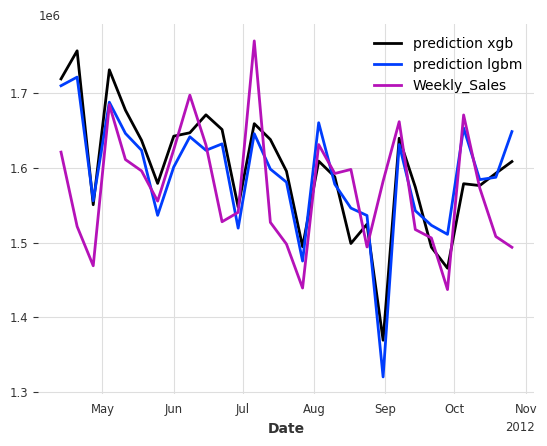

In [28]:
predictions[0].plot(label='prediction xgb')
predictions_lgbm[0].plot(label='prediction lgbm')
y_test[0].plot()

<Axes: xlabel='Date'>

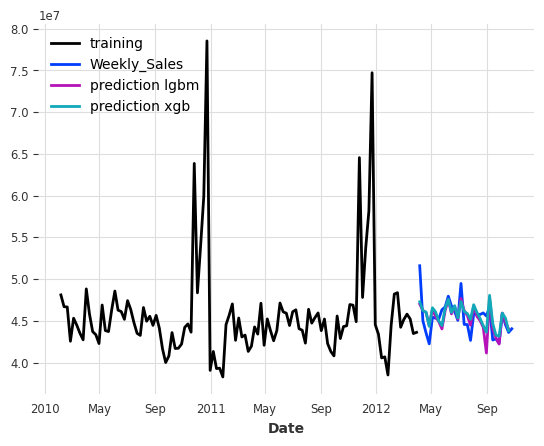

In [31]:
sum(y_train[1:]).plot(label='training')
sum(y_test[1:]).plot()
sum(predictions_lgbm[1:]).plot(label='prediction lgbm')
sum(predictions[1:]).plot(label='prediction xgb')

In [32]:
from darts.metrics.metrics import mape

In [ ]:
lgbm_historical_forecast = model_lgbm.historical_forecasts(series=y_ts,
                                                        future_covariates=future_cov_ts,
                                                        past_covariates=past_cov_ts,
                                                        start=0.5,
                                                        forecast_horizon=10, 
                                                        retrain=True,
                                                        last_points_only=False)

In [39]:
xgb_historical_forecast = model.historical_forecasts(series=y_ts,
                                                        future_covariates=future_cov_ts,
                                                        past_covariates=past_cov_ts,
                                                        start=0.5,
                                                        forecast_horizon=10, 
                                                        retrain=True,
                                                        last_points_only=False)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [40]:
backtest_xgb = model.backtest(series=y_ts,
                                   historical_forecasts=xgb_historical_forecast,
                                   metric=mape,
                                   last_points_only=False,
                                   reduction=None)
backtest_lgbm = model_lgbm.backtest(series=y_ts,
                                   historical_forecasts=lgbm_historical_forecast,
                                   metric=mape,
                                   last_points_only=False,
                                   reduction=None)

In [48]:
means_of_metrics_xgb = [np.mean(metric) for metric in backtest_xgb]
means_of_metrics_lgbm = [np.mean(metric) for metric in backtest_lgbm]

(array([ 3.,  3., 12.,  7.,  7.,  4.,  5.,  3.,  0.,  1.]),
 array([ 3.32809505,  4.18387565,  5.03965624,  5.89543684,  6.75121743,
         7.60699803,  8.46277862,  9.31855922, 10.17433981, 11.03012041,
        11.885901  ]),
 <BarContainer object of 10 artists>)

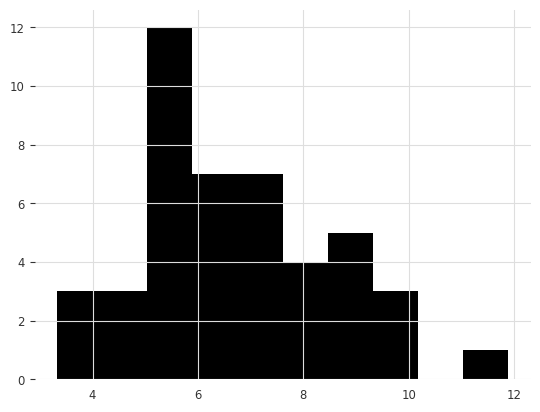

In [49]:
plt.hist(means_of_metrics_xgb)

(array([ 2.,  6.,  2., 15.,  8.,  5.,  1.,  5.,  0.,  1.]),
 array([ 2.77544937,  3.87443078,  4.97341219,  6.0723936 ,  7.17137501,
         8.27035642,  9.36933782, 10.46831923, 11.56730064, 12.66628205,
        13.76526346]),
 <BarContainer object of 10 artists>)

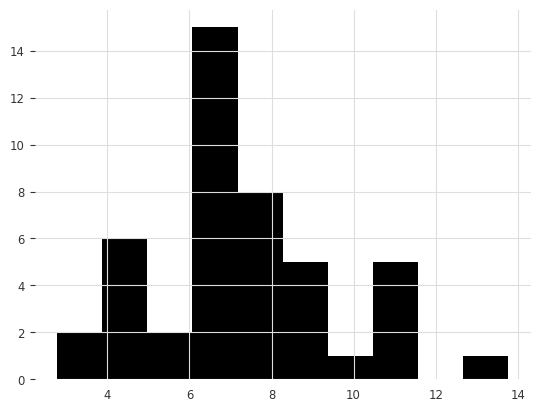

In [50]:
plt.hist(means_of_metrics_lgbm)

In [46]:
np.mean([np.mean(metric) for metric in backtest_xgb])

6.747045483588976

In [47]:
np.mean([np.mean(metric) for metric in backtest_lgbm])

7.232146769342244

Total model predictions performance

In [51]:
total_sales_predictions_xgb = sum(predictions[1:])
total_sales_predictions_lgbm = sum(predictions_lgbm[1:])

In [53]:
mape_xgb = mape(actual_series=sum(y_test[1:]),
                pred_series=total_sales_predictions_xgb)
mape_lgbm = mape(actual_series=sum(y_test[1:]),
                pred_series=total_sales_predictions_lgbm)

In [54]:
print('XGB MAPE%')
print(mape_xgb)
print('=============================')
print('LGBM MAPE%')
print(mape_lgbm)

XGB MAPE%
2.6393264644295527
LGBM MAPE%
2.5887141565130225
